In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from sklearn.preprocessing import StandardScaler
def read(filepath):
    try:
        df = pd.DataFrame(columns=['number', 'id', 'time_sequence'])
        lines = [line.strip() for line in open(filepath,'r')]
        number = int(lines[1].split(" ")[3])
        id = int(lines[2].split(" ")[3])
        print(id)
        matrix = []
        for i in range(5,len(lines)):
            line = lines[i].split(",")
            line = np.array(line).astype(np.float64)
            matrix.append([ *line[:3]])
        #matrix=StandardScaler().fit_transform(matrix)
        
        df.loc[0] = [number, id, matrix]
        return df
    except IOError as e:
        print("Unable to read dataset file!\n")

In [3]:
directory = 'Sketch-Data-master\SketchData\SketchData\Domain01'

df = pd.DataFrame(columns=['number', 'id', 'time_sequence'])
for filename in range(1,1001):
    f = os.path.join(directory, str(filename)+".txt")
    # checking if it is a file
    if os.path.isfile(f):
        df=pd.concat([df,read(f)],ignore_index=True)
        '''le = len(read(f)["time_sequence"].values[0])
        if min > le:
            if le==31:
                print(f)
            min = le'''
# min = 31
#print(df)
#df=preprocess(df)
#print(df)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [ ]:
def cross_validation_split():
    dataset_split = []
    for i in range(10):
        fold=[x for x in range(100*i, 100*(i+1))]
        other=[x for x in range(1000) if x not in fold]
        dataset_split+=[(fold,other)]
    return dataset_split


In [ ]:

def DTWdistance(data1,data2, w):
    n=len(data1)
    m=len(data2)
    data2=StandardScaler().fit_transform(data2)

    DTW=np.zeros((n,m))
    w=max(w,abs(n-m))

    for i in range(n):
        for j in range(m):
            DTW[i,j]=np.inf
    DTW[0,0]=0

    for i in range(1,n):
        for j in range(max(1,i-w),min(m,i+w)):
            DTW[i,j]=0
    
    for i in range(1,n):
        for j in range(max(1,i-w),min(m,i+w)):
            cost=distance(data1[i],data2[j])
            DTW[i,j]=cost+np.min([DTW[i-1,j],#insertion
                                DTW[i,j-1],#deletion
                                DTW[i-1,j-1]])#match
    
    return DTW[n-1,m-1]

def distance(a,b):
    return np.linalg.norm(np.absolute(np.array(a)-np.array(b)))

In [ ]:
print(DTWdistance(df['time_sequence'][0],df['time_sequence'][1],1000))
print(DTWdistance(df['time_sequence'][1],df['time_sequence'][0],1000))
print(DTWdistance(df['time_sequence'][80],df['time_sequence'][81],100))
print(DTWdistance(df['time_sequence'][81],df['time_sequence'][80],100))
print(DTWdistance(df['time_sequence'][200],df['time_sequence'][281],100))
print(DTWdistance(df['time_sequence'][281],df['time_sequence'][200],100))
print(DTWdistance(df['time_sequence'][800],df['time_sequence'][810],100))
print(DTWdistance(df['time_sequence'][810],df['time_sequence'][800],100))
print(DTWdistance(df['time_sequence'][80],df['time_sequence'][810],100))
print(DTWdistance(df['time_sequence'][810],df['time_sequence'][80],100))

76.88554427518726
76.88554427518713
75.83859355552445
75.83859355552444
96.37773633895833
96.37773633895824
57.3736239673831
57.37362396738302
105.0731593997095
105.07315939970923


In [ ]:
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = DTWdistance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

In [ ]:
def dist_matrix(x):
    dist_m = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(i+1,x.shape[0]):
            dist_m[i,j]=DTWdistance(x[i],x[j],100)
            dist_m[j,i]=dist_m[i,j]
        if i%50==0:
            print(i/10, "%")
    return dist_m



In [ ]:
#X = df["time_sequence"].array
#X=dist_matrix(X)
#np.savetxt("dist_matrix2.csv",X,delimiter=",")
#print(X)
X=np.genfromtxt("dist_matrix2.csv",delimiter=",")
for i in range(len(X)):
    for j in range(len(X[i])):
        if(X[i,j]==np.inf):
            X[i,j]=99999999
y = np.array(df["number"].array,dtype=float)

Average accuracy KNN = 0.925
Standard Deviation KNN = 0.07017834423809098
Median KNN = 0.945
[0.87, 0.99, 1.0, 0.93, 0.79, 0.82, 0.94, 0.97, 0.95, 0.99]


'h = 0.02  # step size in the mesh\n\n# Create color maps\ncmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])\ncmap_bold = ["darkorange", "c", "darkblue"]\n\nfor weights in [DTWdistance]:\n    # we create an instance of Neighbours Classifier and fit the data.\n    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric=DTWdistance)\n    clf.fit(X, y)\n\n    # Plot the decision boundary. For that, we will assign a color to each\n    # point in the mesh [x_min, x_max]x[y_min, y_max].\n    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1\n    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))\n    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])\n\n    # Put the result into a color plot\n    Z = Z.reshape(xx.shape)\n    plt.figure(figsize=(8, 6))\n    plt.contourf(xx, yy, Z) #cmap=cmap_light)\n\n    # Plot also the training points\n    sns.scatterplot(\n        x=X[:, 0],\n

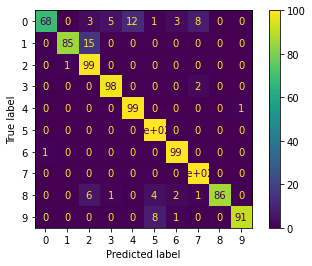

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

n_neighbors = 5

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset

scores_KNN=[]
scores_SVC=[]
conf_matrix=np.zeros((10,10))
for test_ind, train_ind in cross_validation_split():
    x_train, y_train = X[train_ind], y[train_ind]
    x_train=x_train[:,train_ind]
    x_test, y_test = X[test_ind], y[test_ind]
    x_test=x_test[:,train_ind]
    #print(x_train)
    clf = neighbors.KNeighborsClassifier(n_neighbors, metric="precomputed")
    clf.fit(x_train, y_train)
    scores_KNN+=[clf.score(x_test,y_test)]
    conf_matrix+=confusion_matrix(y_test,clf.predict(x_test))
    #sv=SVC(kernel='precomputed',C=1000, gamma='auto')
    #sv.fit(x_train,y_train)
    #scores_SVC+=[sv.score(x_test,y_test)]

print("Average accuracy KNN = "+str(np.mean(scores_KNN)))
print("Standard Deviation KNN = "+str(np.std(scores_KNN)))
print("Median KNN = "+str(np.median(scores_KNN)))
print(scores_KNN)
disp=ConfusionMatrixDisplay(conf_matrix)
disp.plot()

#print("Average accuracy SVC = "+str(np.mean(scores_SVC)))
#print("Standard Deviation SVC = "+str(np.std(scores_SVC)))
#print(scores_SVC)


'''h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in [DTWdistance]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric=DTWdistance)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z) #cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        #hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()'''

## Dollar Recognizer

In [4]:
from DollarRecognizer import Recognizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [5]:
#
#  The $1 Gesture Recognizer
#
#      Jacob O. Wobbrock
#      The Information School
#      University of Washington
#      Mary Gates Hall, Box 352840
#      Seattle, WA 98195-2840
#      wobbrock@u.washington.edu
#
#      Andrew D. Wilson
#      Microsoft Research
#      One Microsoft Way
#      Redmond, WA 98052
#      awilson@microsoft.com
#
#      Yang Li
#      Department of Computer Science and Engineering
#      University of Washington
#      The Allen Center, Box 352350
#      Seattle, WA 98195-2840
#      yangli@cs.washington.edu
#
# Python port:
# Charlie Von Metzradt, November 2008
# http://sleepygeek.org
#
# Usage example:
#
# from dollar import Recognizer
#
# r = Recognizer()
# r.addTemplate('square', [(1, 10), (3, 8) ... ])
# r.addTemplate('circle', [(4, 7), (5, 13) ... ])
#
# (name, score) = r.recognize([(5, 6), (7, 12), ... ])
#

import math
import numpy as np

# Contants. Tweak at your peril. :)

numPoints      = 100
cubeSize       = 25.0
halfDiagonal   = 0.5 * math.sqrt(cubeSize * cubeSize + cubeSize * cubeSize + cubeSize * cubeSize)
angleRange     = 45.0
anglePrecision = 2.0
phi            = 0.5 * (-1.0 + math.sqrt(5.0)) # Golden Ratio
 
class Recognizer:
   """The $1 gesture recognizer. See http://sleepygeek.org/projects.dollar for more, or http://depts.washington.edu/aimgroup/proj/dollar/ for the original implementation and paper."""
   templates = set()

   def recognize(self, points):
      """Determine which gesture template most closely matches the gesture represented by the input points. 'points' is a list of tuples, eg: [(1, 10), (3, 8) ...]. Returns a tuple of the form (name, score) where name is the matching template, and score is a float [0..1] representing the match certainty."""

      points = [Point(point[0], point[1], point[2]) for point in points]
      points = _resample(points, numPoints);
      points = _rotateToZero(points);
      points = _scaleToSquare(points, cubeSize);
      points = _translateToOrigin(points);
      
      bestDistance = float("infinity")
      bestTemplate = None
      for template in self.templates:
         distance = _distanceAtBestAngle(points, template, -angleRange, +angleRange, anglePrecision)
         if distance < bestDistance:
            bestDistance = distance
            bestTemplate = template

      score = 1.0 - (bestDistance / halfDiagonal)
      return (bestTemplate.name, score)

   def addTemplate(self, name, points):
      """Add a new template, and assign it a name. Multiple templates can be given the same name, for more accurate matching. Returns an integer representing the number of templates matching this name."""
      self.templates.add(Template(name, points))
      
      # Return the number of templates with this name.
      return len([t for t in self.templates if t.name == name])

   def deleteTemplates(self, name):
      """Remove all templates matching a given name. Returns an integer representing the new number of templates."""

      self.templates = [t for t in self.templates if t.name != name]
      return len(self.templates);
   
class Point:
   """Simple representation of a point."""
   def __init__(self, x, y, z):
      self.x = x
      self.y = y
      self.z = z
   def __str__(self) -> str:
       return str(self.x)+str(self.y)+str(self.z)

class Rectangle:
   """Simple representation of a rectangle."""
   def __init__(self, x, y, z, width, height, depth):
      self.x = x
      self.y = y
      self.z = z
      self.width = width
      self.height = height
      self.depth = depth

class Template:
   """A gesture template. Used internally by Recognizer."""
   def __init__(self, name, points):
      """'name' is a label identifying this gesture, and 'points' is a list of tuple co-ordinates representing the gesture positions. Example: [(1, 10), (3, 8) ...]"""
      self.name = name
      self.points = [Point(point[0], point[1], point[2]) for point in points]
      self.points = _resample(self.points, numPoints);
      self.points = _rotateToZero(self.points);
      self.points = _scaleToSquare(self.points, cubeSize);
      self.points = _translateToOrigin(self.points);
      
   def __hash__(self) -> int:
      return hash(self.name + ''.join([str(point) for point in self.points]))

def _resample(points, n):
   """Resample a set of points to a roughly equivalent, evenly-spaced set of points."""
   I = _pathLength(points) / (n - 1) # interval length
   D = 0.0
   newpoints = [points[0]]
   i = 1
   while i < len(points) - 1:
      d = _distance(points[i - 1], points[i])
      if (D + d) >= I:
         qx = points[i - 1].x + ((I - D) / d) * (points[i].x - points[i - 1].x)
         qy = points[i - 1].y + ((I - D) / d) * (points[i].y - points[i - 1].y)
         qz = points[i - 1].z + ((I - D) / d) * (points[i].z - points[i - 1].z)
         q = Point(qx, qy, qz)
         newpoints.append(q)
         # Insert 'q' at position i in points s.t. 'q' will be the next i
         points.insert(i, q)
         D = 0.0
      else:
         D += d
      i += 1
    
   #
   # Sometimes we fall a rounding-error short of adding the last point, so add it if so.   
   while (len(newpoints) < n):
      newpoints.append(points[-1])   
   return newpoints;

def _rotateToZero(points):
   """Rotate a set of points such that the angle between the first point and the centre point is 0."""
   c = _centroid(points)
   theta = math.atan2(c.y - points[0].y, c.x - points[0].x)
   return _rotateBy(points, -theta)

def _rotateBy(points, theta):
   """Rotate a set of points by a given angle."""
   c = _centroid(points);
   cos = math.cos(theta);
   sin = math.sin(theta);
   
   newpoints = [];
   for point in points:
      qx = (point.x - c.x) * cos - (point.y - c.y) * sin + c.x
      qy = (point.x - c.x) * sin + (point.y - c.y) * cos + c.y
      qz = point.z
      newpoints.append(Point(qx, qy, qz))
   return newpoints

def _scaleToSquare(points, size):
   """Scale a scale of points to fit a given bounding box."""
   B = _boundingBox(points)
   newpoints = []
   for point in points:
      qx = point.x * (size / B.width)
      qy = point.y * (size / B.height)
      qz = point.z * (size / B.depth)
      newpoints.append(Point(qx, qy, qz))
   return newpoints

def _translateToOrigin(points):
   """Translate a set of points, placing the centre point at the origin."""
   c = _centroid(points)
   newpoints = []
   for point in points:
      qx = point.x - c.x
      qy = point.y - c.y
      qz = point.z - c.z
      newpoints.append(Point(qx, qy, qz))
   return newpoints;

def _distanceAtBestAngle(points, T, a, b, threshold):
   """Search for the best match between a set of points and a template, using a set of tolerances. Returns a float representing this minimum distance."""
   x1 = phi * a + (1.0 - phi) * b
   f1 = _distanceAtAngle(points, T, x1)
   x2 = (1.0 - phi) * a + phi * b
   f2 = _distanceAtAngle(points, T, x2)

   while abs(b - a) > threshold:
      if f1 < f2:
         b = x2
         x2 = x1
         f2 = f1
         x1 = phi * a + (1.0 - phi) * b
         f1 = _distanceAtAngle(points, T, x1)
      else:
         a = x1
         x1 = x2
         f1 = f2
         x2 = (1.0 - phi) * a + phi * b
         f2 = _distanceAtAngle(points, T, x2)
   return min(f1, f2)

def _distanceAtAngle(points, T, theta):
   """Returns the distance by which a set of points differs from a template when rotated by theta."""
   newpoints = _rotateBy(points, theta)
   return _pathDistance(newpoints, T.points)

def _centroid(points):
   """Returns the centre of a given set of points."""
   x = 0.0
   y = 0.0
   z = 0.0
   for point in points:
      x += point.x
      y += point.y
      z += point.z
   x /= len(points)
   y /= len(points)
   z /= len(points)
   return Point(x, y, z)

def _boundingBox(points):
   """Returns a Rectangle representing the bounding box that contains the given set of points."""
   minX = float("+Infinity")
   maxX = float("-Infinity")
   minY = float("+Infinity")
   maxY = float("-Infinity")
   minZ = float("+Infinity")
   maxZ = float("-Infinity")

   for point in points:
      if point.x < minX:
         minX = point.x
      if point.x > maxX:
         maxX = point.x
      if point.y < minY:
         minY = point.y
      if point.y > maxY:
         maxY = point.y
      if point.z < minZ:
         minZ = point.z
      if point.z > maxZ:
         maxZ = point.z

   return Rectangle(minX, minY, minZ, maxX - minX, maxY - minY, maxZ - minZ)

def _pathDistance(pts1, pts2):
   """'Distance' between two paths."""
   d = 0.0;
   for index in range(len(pts1)): # assumes pts1.length == pts2.length
      d += _distance(pts1[index], pts2[index])
   return d / len(pts1)

def _pathLength(points):
   """Sum of distance between each point, or, length of the path represented by a set of points."""
   d = 0.0;
   for index in range(1, len(points)):
      d += _distance(points[index - 1], points[index])
   return d

def _distance(p1, p2):
   """Distance between two points."""
   dx = p2.x - p1.x
   dy = p2.y - p1.y
   dz = p2.z - p1.z
   return math.sqrt(dx * dx + dy * dy + dz * dz)

Average accuracy 3D $1 = 0.9960000000000001
Standard Deviation 3D $1 = 0.012000000000000009
Median 3D $1 = 1.0


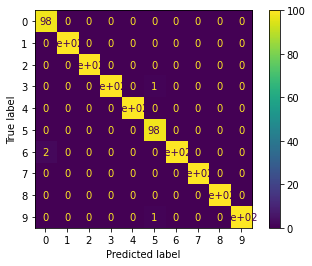

In [7]:
scores = np.zeros((10))
conf_matrix=np.zeros((10,10))
for u in range(10):
    recognizer = Recognizer()
    for user in range(10):
        if user!=u:
            for num in range(10):
                for i in range(10):
                    recognizer.addTemplate(str(num+1), df['time_sequence'][user*100+num*10+i])
    
    for i in range(10):
        for j in range(10):
            result = recognizer.recognize(df['time_sequence'][u*100+i*10+j])
            conf_matrix[int(result[0]) - 1, i] += 1
            if result[0]==str(i+1):
                scores[u]+=1
    scores[u] /= 100
                
print("Average accuracy 3D $1 = "+str(np.mean(scores)))
print("Standard Deviation 3D $1 = "+str(np.std(scores)))
print("Median 3D $1 = "+str(np.median(scores)))
disp=ConfusionMatrixDisplay(conf_matrix)
disp.plot()

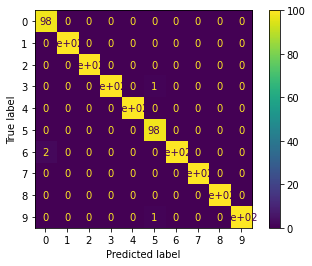

In [8]:
disp=ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.savefig("confusionDollar.pdf")
recognizer.addTemplate(str(num+1), df['time_sequence'][user*100+num*10+i])